In [9]:
import pandas as pd
import seaborn as sns
import os 
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# load data
df_dict = {}

for file in os.listdir("../final_data"):
   if file.endswith(".tsv"):
        filename = os.path.splitext(os.path.basename(file))[0]
        temp_df = pd.read_csv(os.path.join('../final_data', file), delimiter='\t')
        df_dict[filename] = temp_df

cost_df = df_dict['cost']

# since coffins column is missing values, add the coffin column from coffins.tsv
coffins_df = df_dict['coffins']
merged_df = cost_df.merge(coffins_df, left_on="coffins", right_on="total_cost", how="left")
cost_df["coffins"] = cost_df["coffins"].fillna(merged_df["coffins"])

# some of the missing values have different keys - filling in manually
# found this value in coffins_df
cost_df.at[0, "coffins"] = 590.0
# cannot find k&m in coffins_df, in paper, it says that Kha and Merit are similar to Yuya and Tuya, so filling their coffin value wih 590
cost_df.at[2, "coffins"] = 590.0

# filling in missing jewelry values
jewel_df = df_dict['jewel']
# putting 0 for iabtina because appendix in paper says there is no jewelry
cost_df.at[25, "jewlery"] = 0
# cannot find data for NuMan, putting 85 which is the average of the rank above and rank below cost on jewelry
cost_df.at[75, "jewlery"] = 85
cost_df = cost_df.rename(columns = {"jewlery" : "jewelry"})

# filling in missing values for profess
proff_df = df_dict['proff']
# no professional equipment for Sat-Re, filling in 0
cost_df.at[29, "profess"] = 0

# filling in missing values for toiletries 
# no information about toiletries for Khay, filling in the average of the rank above and below
cost_df.at[5, "toiletries"] = 13.5
# drop some repeat tombs
cost_df = cost_df[~cost_df['tomb'].isin(['Yuya','Kha', 'Merit', "Tuya", "T&A"])]

print(cost_df.isnull().sum())
cost_df = cost_df.drop(["rank"], axis=1)

def assign_manual_label(row):
    tut = ["Tutankhamen"]
    elite = ["Y&T", "K&M", "Mahirper"]
    high_mid = ["Nakht", "Khay", "Hatnofer", "Nerferkhewet", "Hatiay", "Setau", "Sennofer", "Petrie"]
    mid = ["Tahuty", "Ahotep", "Harmose", "Mentuhotep", "Senmut"]
    

    if row["tomb"] in tut:
        return "Tutankhamen"
    elif row["tomb"] in elite:
        return "Elite"
    elif row["tomb"] in high_mid:
        return "High-Middle"
    elif row["tomb"] in mid:
        return "Middle"
    else:
        return "Low"

# assign status from paper 
cost_df["status"] = cost_df.apply(assign_manual_label, axis=1)

# create group dataframes
elite_df = cost_df[cost_df["status"] == "Elite"]
high_mid_df = cost_df[cost_df["status"] == "High-Middle"]
mid_df = cost_df[cost_df["status"] == "Middle"]
low_df = cost_df[cost_df["status"] == "Low"]

df_list = [elite_df, high_mid_df, mid_df, low_df]

# drop tomb and status because they are strings
feature_matrix = cost_df.drop(['tomb', 'status'], axis=1)

# create feature matrix for PCA
feature_matrix = StandardScaler().fit_transform(feature_matrix)


tomb           0
rank           0
grand_total    0
amphorae       0
bouquet        0
bowls          0
boxbas         0
coffins        0
fertility      0
funerary       0
furniture      0
jars           0
jewelry        0
personal       0
profess        0
shabti         0
toiletries     0
vessels        0
dtype: int64


In [10]:
# PCA
from sklearn.decomposition import PCA

# create PCA features
pca = PCA(n_components=2)
feature_matrix = pca.fit_transform(feature_matrix)

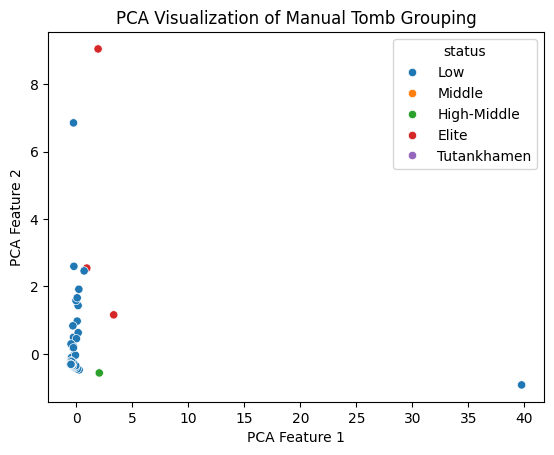

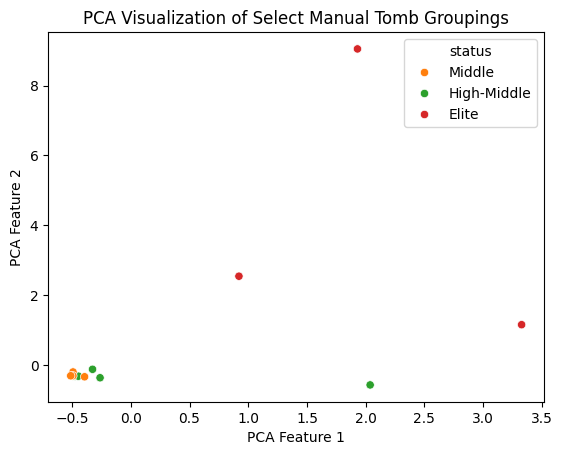

In [ ]:
# assign manual labels 

fm_df = pd.DataFrame(feature_matrix)
fm_df['status'] = cost_df["status"]
fm_df.columns = ['feature1', 'feature2', 'status']

# sort status and assign colors for plotting
status_order = ['Low', 'Middle', 'High-Middle', 'Elite', 'Tutankhamen']
base_palette = sns.color_palette('tab10', len(status_order))
status_colors = {c: base_palette[i] for i, c in enumerate(status_order)}

# plot statuss
sns.scatterplot(data=fm_df, x='feature1', y='feature2', hue='status',
                palette=status_colors, hue_order=status_order)
plt.title('PCA Visualization of Manual Tomb Groupings')
plt.ylabel('PCA Feature 2')
plt.xlabel('PCA Feature 1')
plt.show()

# filter and plot corner statuss to see them better
filtered = fm_df[~fm_df['status'].isin(["Low", 'Tutankhamen'])]
status_order_subset = ['Middle', 'High-Middle', 'Elite']  # subset only changes order

plt.clf()
sns.scatterplot(data=filtered, x='feature1', y='feature2', hue='status',
                palette=status_colors, hue_order=status_order_subset)
plt.title('PCA Visualization of Select Manual Tomb Groupings')
plt.ylabel('PCA Feature 2')
plt.xlabel('PCA Feature 1')
plt.show()

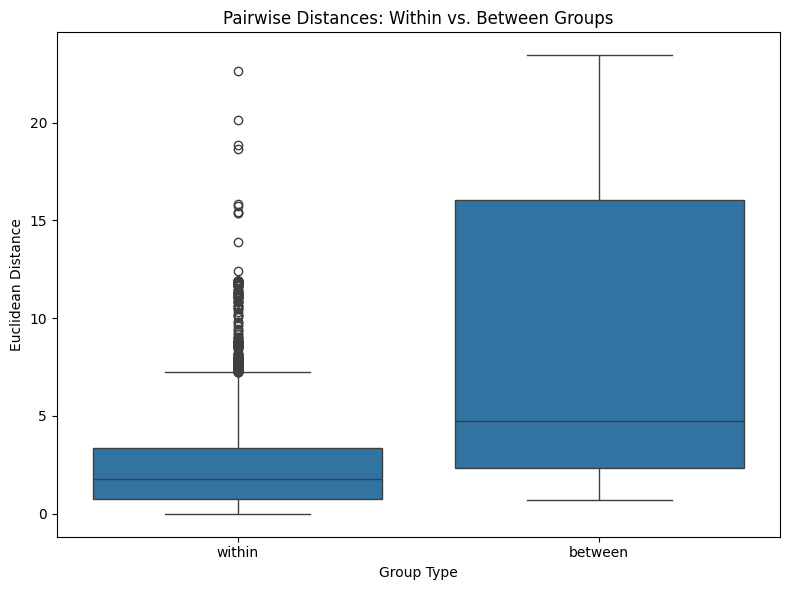

In [38]:
# pairwise distances visualizations 
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix

no_tut = cost_df[cost_df['tomb'] != "Tutankhamen"]
nt_fm = no_tut.drop(['tomb', 'status'], axis=1)
nt_fm = StandardScaler().fit_transform(nt_fm)

# calculate distance matrix
distances = pdist(nt_fm, metric='euclidean')
dist_matrix = DistanceMatrix(squareform(distances), ids=no_tut["tomb"])

# get group labels
group_labels = no_tut['status'].values
tomb_ids = no_tut['tomb'].values

data = []

# gather pairwise distances (exlcuding duplicates)
for i in range(len(tomb_ids) - 1):
    for j in range(i + 1, len(tomb_ids)):
        tomb1 = tomb_ids[i]
        tomb2 = tomb_ids[j]
        group1 = group_labels[i]
        group2 = group_labels[j]
        dist = dist_matrix[tomb1, tomb2]
        label = 'within' if group1 == group2 else 'between'
        data.append({'Tomb1': tomb1, 'Tomb2': tomb2, 'Distance': dist, 'Type': label})

distance_df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
sns.boxplot(data=distance_df, x='Type', y='Distance')
plt.title('Pairwise Distances: Within vs. Between Groups')
plt.ylabel('Euclidean Distance')
plt.xlabel('Group Type')
plt.tight_layout()
plt.show()


In [42]:
# outlier analysis 
from collections import Counter

within_df = distance_df[distance_df['Type'] == 'within']

Q1 = within_df['Distance'].quantile(0.25)
Q3 = within_df['Distance'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

outliers_df = within_df[within_df['Distance'] > upper_bound]

from collections import Counter

tomb_counts = Counter(outliers_df['Tomb1'].tolist() + outliers_df['Tomb2'].tolist())
most_common = tomb_counts.most_common()

outlier_summary = pd.DataFrame(most_common, columns=['Tomb', 'Frequency'])
print(outlier_summary.head(20))

            Tomb  Frequency
0    Neferkhewet        118
1            S&N        117
2             M+        103
3           Boki         85
4        Renofer         64
5           Ruyu          7
6             S+          7
7       Hatnofer          6
8          Setau          6
9            Nu+          6
10  Pit 3 Room B          5
11       # 83 3c          5
12        Room C          5
13        # 22 f          5
14        # 34 ?          5
15        # 36 ?          5
16        # 37 f          5
17        # 38 ?          5
18        # 43 c          5
19        # 47 f          5
